In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.cross_validation import train_test_split

from gini import normalized_gini, gini_eval
from dataset import get_data

from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity, KNeighborsRegressor

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#import pylab as pl

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

params = pd.DataFrame({
    "objective": "reg:linear",
    "eta": [0.04, 0.03, 0.03, 0.03, 0.02],
    "min_child_weight": 5,
    "subsample": [1, 0.9, 0.95, 1, 0.6],
    "colsample_bytree": [0.7, 0.6, 0.65, 0.6, 0.85],
    "max_depth": [8, 7, 9, 10, 10],
    "eval_metric": "auc",
    "scale_pos_weight": 1,
    "silent": 1
})


dat_x, dat_y, lb_x, lb_ind = get_data()

dat_y = dat_y # ** 0.75
dat_x['label'] = dat_y
#dat_x = dat_x[dat_x['label'] < 6]
dat_y = np.asarray(dat_x['label'])
dat_x = dat_x.drop('label', axis=1)

seen_index, unseen_index = train_test_split(range(dat_x.shape[0]), test_size=0.1, random_state=101)
train_index, test_index = train_test_split(range(dat_x.shape[0]), test_size=0.1, random_state=103)

train_x = dat_x.iloc[train_index, :]
train_y = dat_y[train_index]
cv_x = dat_x.iloc[test_index, :]
cv_y = dat_y[test_index]

cv_x_low = cv_x[cv_y < 40]
cv_y_low = cv_y[cv_y < 40]

# model 1
xgb_train = xgb.DMatrix(train_x, label=train_y)
xgb_cv = xgb.DMatrix(cv_x, label=cv_y)
xgb_cv_low = xgb.DMatrix(cv_x_low, label=cv_y_low)
watchlist = [(xgb_cv_low, 'cv_low'), (xgb_cv, 'cv')]
model = xgb.train(params.iloc[0,:].to_dict(), xgb_train, num_boost_round = 3000,
                  evals = watchlist,
                  feval = gini_eval,
                  verbose_eval = True,
                  early_stopping_rounds=50)
cv_y_preds = model.predict(xgb_cv, ntree_limit=model.best_iteration)
cv_y_low_preds = model.predict(xgb_cv_low, ntree_limit=model.best_iteration)

/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
Will train until cv error hasn't decreased in 50 rounds.
[0]	cv_low-Gini:0.295158	cv-Gini:0.293077
[1]	cv_low-Gini:0.318799	cv-Gini:0.325366
[2]	cv_low-Gini:0.330807	cv-Gini:0.336736
[3]	cv_low-Gini:0.340474	cv-Gini:0.346465
[4]	cv_low-Gini:0.343601	cv-Gini:0.349209
[5]	cv_low-Gini:0.346647	cv-Gini:0.351191
[6]	cv_low-Gini:0.342959	cv-Gini:0.345645
[7]	cv_low-Gini:0.348424	cv-Gini:0.351029
[8]	cv_low-Gini:0.348346	cv-Gini:0.352753
[9]	cv_low-Gini:0.349543	cv-Gini:0.354585
[10]	cv_low-Gini:0.351684	cv-Gini:0.356740
[11]	cv_low-Gini:0.353762	cv-Gini:0.358338
[12]	cv_low-Gini:0.353143	cv-Gini:0.358561
[13]	cv_low-Gini:0.356104	cv-Gini:0.361434
[14]	cv_low-Gini:0.356053	cv-Gini:0.361561
[15]	cv_low-Gini:0.356040	cv-Gini:0.361389
[16]	cv_l

In [2]:
print("CV MSE=%0.3f"%(sum(np.power( cv_y_preds - cv_y, 2 ))/cv_y.shape[0]))
print("CV LOW MSE=%0.3f"%(sum(np.power( cv_y_low_preds - cv_y_low, 2 ))/cv_y_low.shape[0]))
cv_error = normalized_gini(cv_y, cv_y_preds)
cv_low_error = normalized_gini(cv_y_low, cv_y_low_preds)
print("CV: {:.10f} (normalized gini).".format(cv_error))
print("CV LOW: {:.10f} (normalized gini).".format(cv_low_error))

CV MSE=15.628
CV LOW MSE=14.549
CV: 0.3895811983 (normalized gini).
CV LOW: 0.3831808365 (normalized gini).


CV MSE=15.552
CV LOW MSE=14.444
CV: 0.3920835485 (normalized gini).
CV LOW: 0.3870119302 (normalized gini).


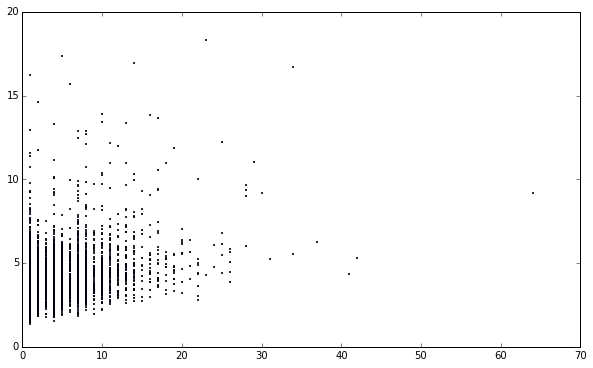

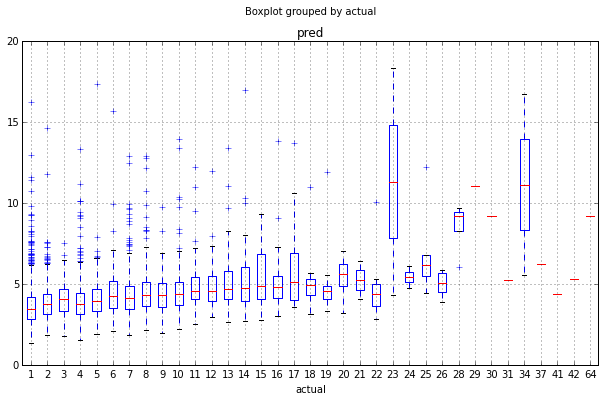

In [6]:
print("CV MSE=%0.3f"%(sum(np.power( cv_y_preds - cv_y, 2 ))/cv_y.shape[0]))
print("CV LOW MSE=%0.3f"%(sum(np.power( cv_y_low_preds - cv_y_low, 2 ))/cv_y_low.shape[0]))
cv_error = normalized_gini(cv_y, cv_y_preds)
cv_low_error = normalized_gini(cv_y_low, cv_y_low_preds)
print("CV: {:.10f} (normalized gini).".format(cv_error))
print("CV LOW: {:.10f} (normalized gini).".format(cv_low_error))

max_cy = max(cv_y) * 1.1

#plt.subplot(1, 2, 1)
plt.scatter(cv_y, cv_y_preds, s=1)
plt.xlim(0, 70)

preds = pd.DataFrame({"actual": cv_y, "pred": cv_y_preds})
preds.boxplot('pred', 'actual')

plt.show()

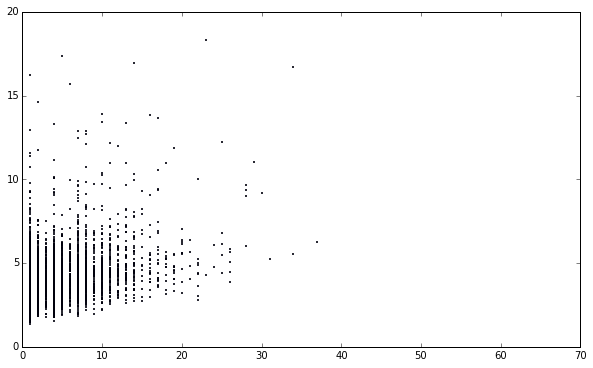

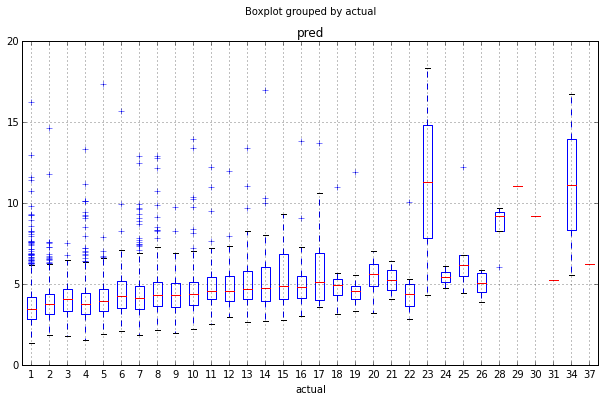

In [5]:
max_cy = max(cv_y_low) * 1.1

#plt.subplot(1, 2, 1)
plt.scatter(cv_y_low, cv_y_low_preds, s=1)
plt.xlim(0, 70)

preds = pd.DataFrame({"actual": cv_y_low, "pred": cv_y_low_preds})
preds.boxplot('pred', 'actual')

plt.show()

In [ ]:
len(cv_y)

In [ ]:
len(cv_y_low)

In [ ]:
max(train_y), max(cv_y)

In [ ]:
2.5 ** (3./4)

In [ ]:
cv_y_low = cv_y[cv_y < 19.5]